   # <center> ScamShield  </center>
   # <center> Employment Hoax Postings Analysis using ML Models and NLP </center>
   
   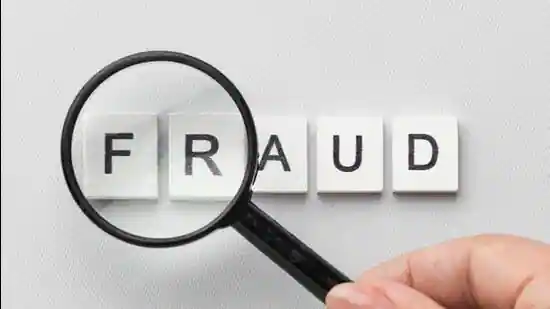

---

## About the Dataset:

* The [Real or Fake] : Fake Job Description Prediction Dataset is a collection of job descriptions designed for the purpose of creating classification models capable of distinguishing between genuine and fraudulent job postings. The dataset consists of 18,000 job descriptions, with approximately 800 of them labeled as fake. These job descriptions are accompanied by both textual information and meta-information related to the jobs.


## Dataset Details:

* **Source:** The dataset has been curated by the Laboratory of Information & Communication Systems Security at the University of the Aegean.


* **Objective:** The primary objective of this dataset is to enable the development and evaluation of machine learning models for detecting fraudulent job descriptions.


* **Contents:** The dataset contains two main types of data:


* **Textual Information:** The text of the job descriptions, which provides the core content for analysis and classification.

* **Meta-information:** Additional details about the jobs, which can serve as features for enhancing the classification models.


* **Size:** The dataset comprises 18,000 job descriptions, with a subset of around 800 job descriptions marked as fake.



## Applications:

* **Classification Models:** Researchers and data scientists can employ the dataset to train classification models that use both text data features and meta-features to predict whether a given job description is genuine or fraudulent.


* **Feature Identification:** Analysis of the dataset can help in identifying key traits and features associated with fraudulent job descriptions, aiding in the creation of more effective detection mechanisms.


* **Contextual Embeddings:** Contextual embedding models can be applied to find similarities between job descriptions, revealing patterns and relationships within the dataset.


* **Exploratory Data Analysis:** Exploring the dataset can uncover insights about the distribution of real and fake job descriptions, as well as common linguistic patterns in each category.

## --Required Libraries

In [1]:
import re
import string
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from imblearn.combine import SMOTETomek


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('fake_job_postings.csv')

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
rows, cols = df.shape
pd.DataFrame({'Records': [rows], 'Features': [cols]}, index=['Shape'])

,Records,Features
Shape,17880,18


______________________________________________________________________

### --Feature Analysis

In [5]:
def categorical_numerical_table(df):
    """
    Creates a table with categorical and numerical column names from a DataFrame.
    """
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns.tolist()
    aligned_columns = list(zip_longest(categorical_columns, numeric_columns, fillvalue=''))
    column_table = pd.DataFrame({'Categorical Columns': [cat_col for cat_col, num_col in aligned_columns],
                                 'Numerical Columns': [num_col for cat_col, num_col in aligned_columns]},
                                index=range(1, len(aligned_columns) + 1))

    return column_table


categorical_columns = categorical_numerical_table(df)['Categorical Columns'].tolist()
numerical_columns = categorical_numerical_table(df)['Numerical Columns'].tolist()
categorical_numerical_table(df)

,Categorical Columns,Numerical Columns
1,title,job_id
2,location,telecommuting
3,department,has_company_logo
4,salary_range,has_questions
5,company_profile,fraudulent
6,description,
7,requirements,
8,benefits,
9,employment_type,
10,required_experience,


_______________________________________________________________________________________

### --Numerical Features Analysis

In [6]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

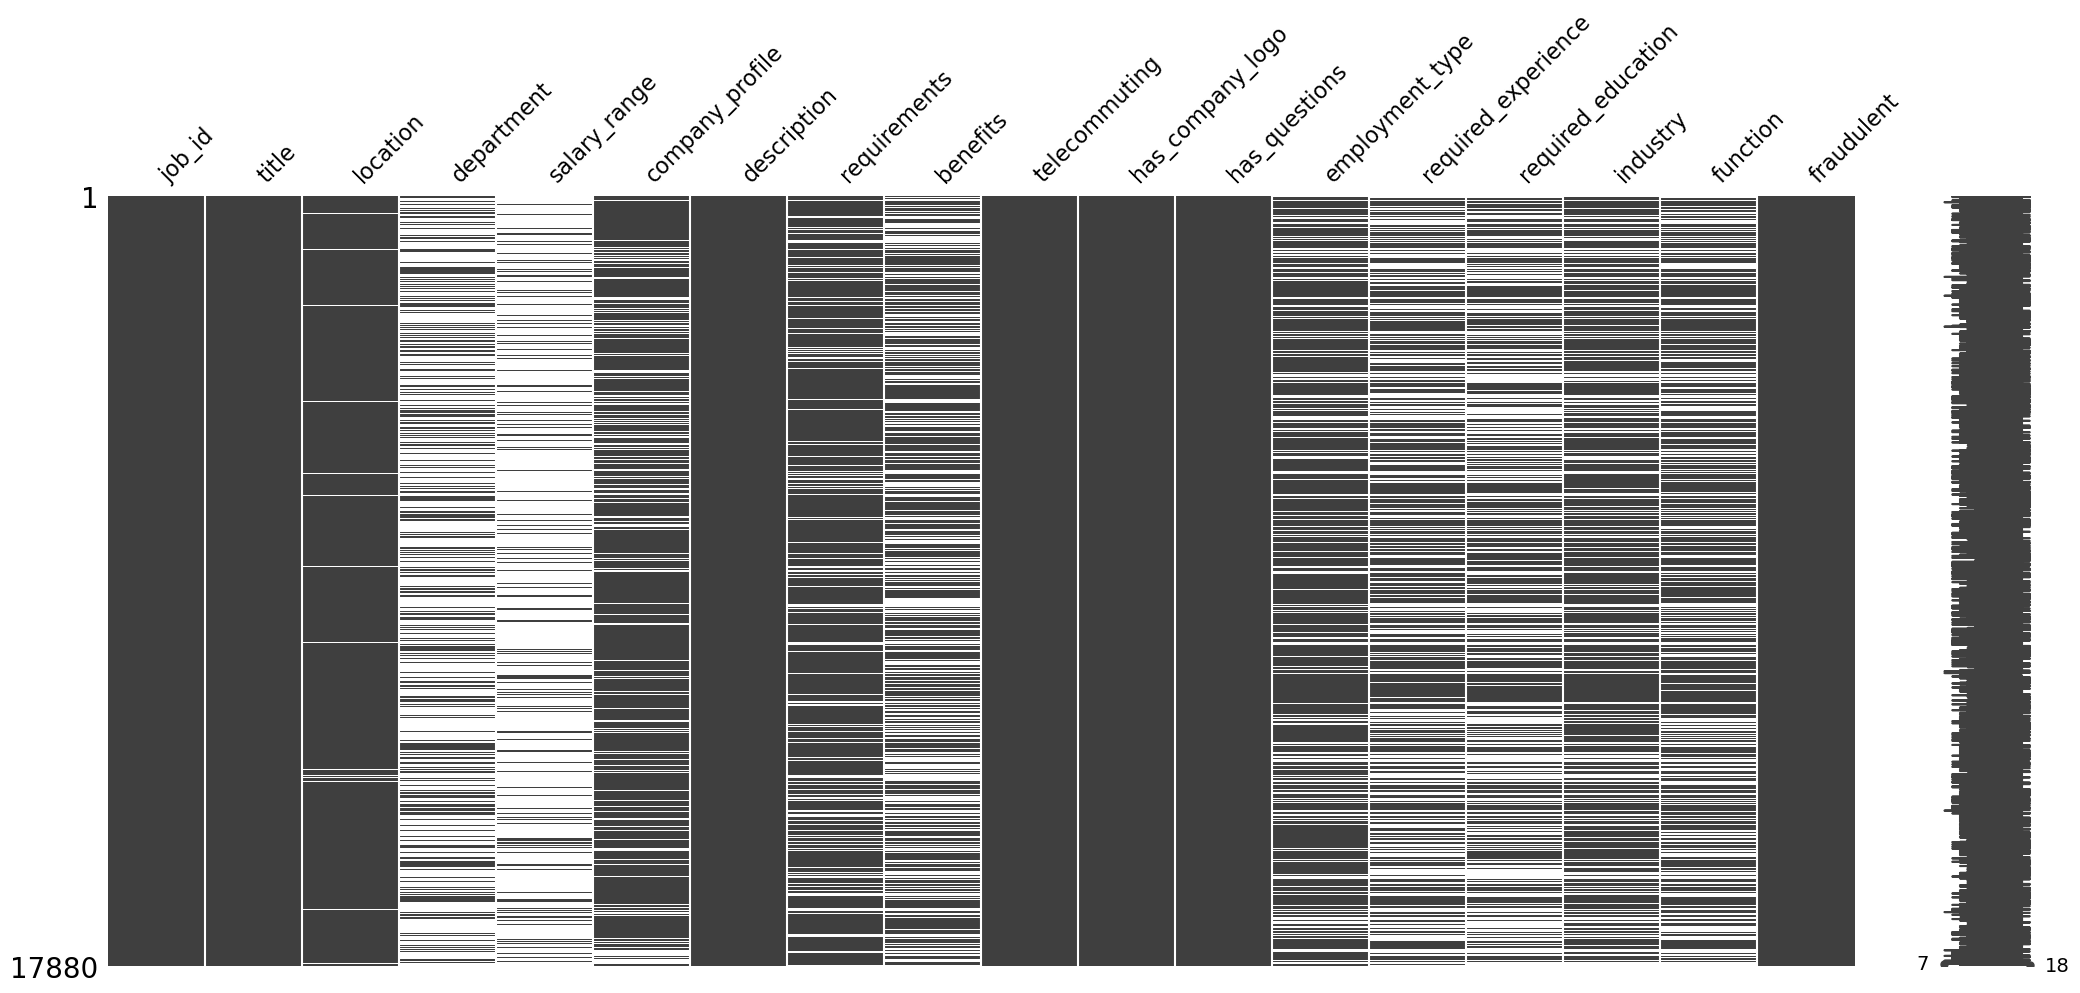

In [7]:
# checking missing data in our dataframe.
missingno.matrix(df)

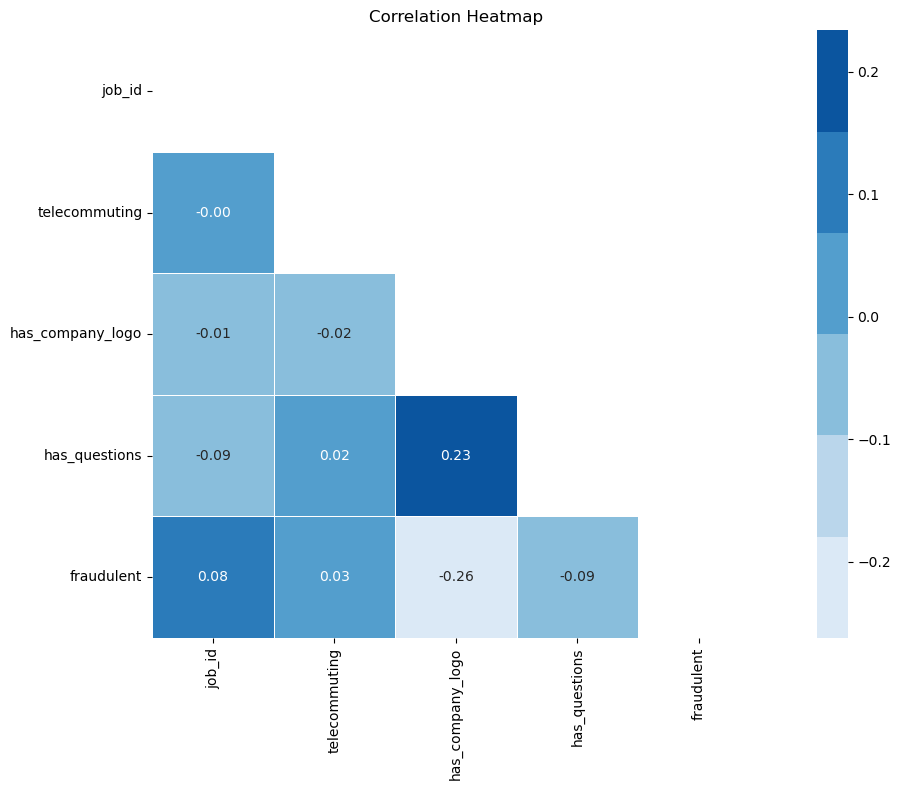

In [8]:
plt.figure(figsize=(12, 8))
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.color_palette("Blues")
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", mask=mask, linewidths=0.5, square=True)

plt.title("Correlation Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


The correlations between most of the variables are relatively weak, with values close to zero. This suggests that there may not be strong linear relationships between these variables.


It's important to note that correlation does not imply causation.

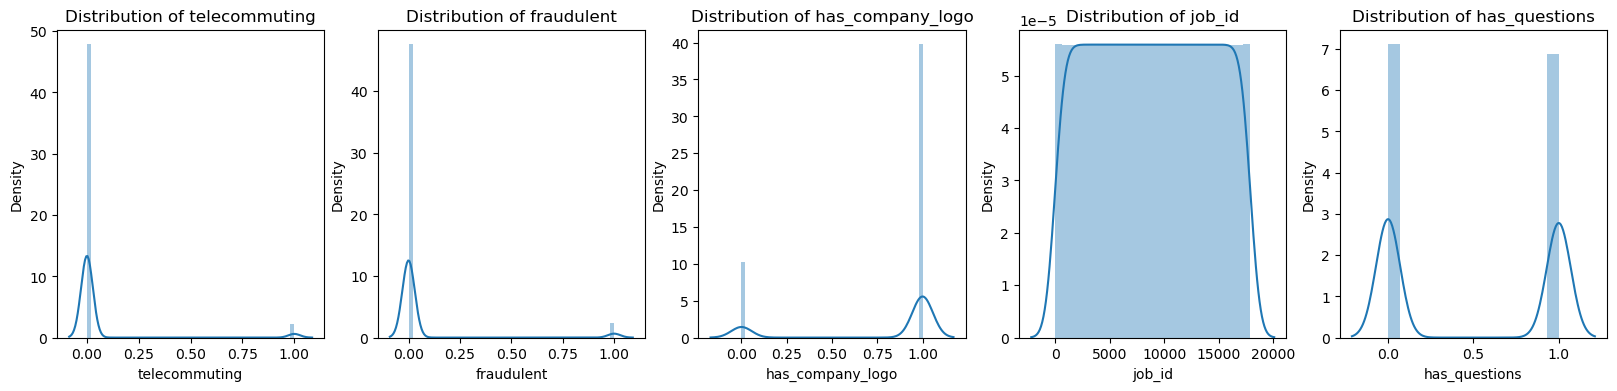

In [9]:
def check_normal(df):
    categorical_columns = [column_name for column_name in df if df[column_name].dtype == 'O']
    numerical_columns = list(set(df.columns) - set(categorical_columns))

    fig, axes = plt.subplots(1, len(numerical_columns), figsize=(20, 4))

    for i, numeric_column_name in enumerate(numerical_columns):
        sns.distplot(df[numeric_column_name], ax=axes[i])
        axes[i].set_title(f'Distribution of {numeric_column_name}')

check_normal(df)

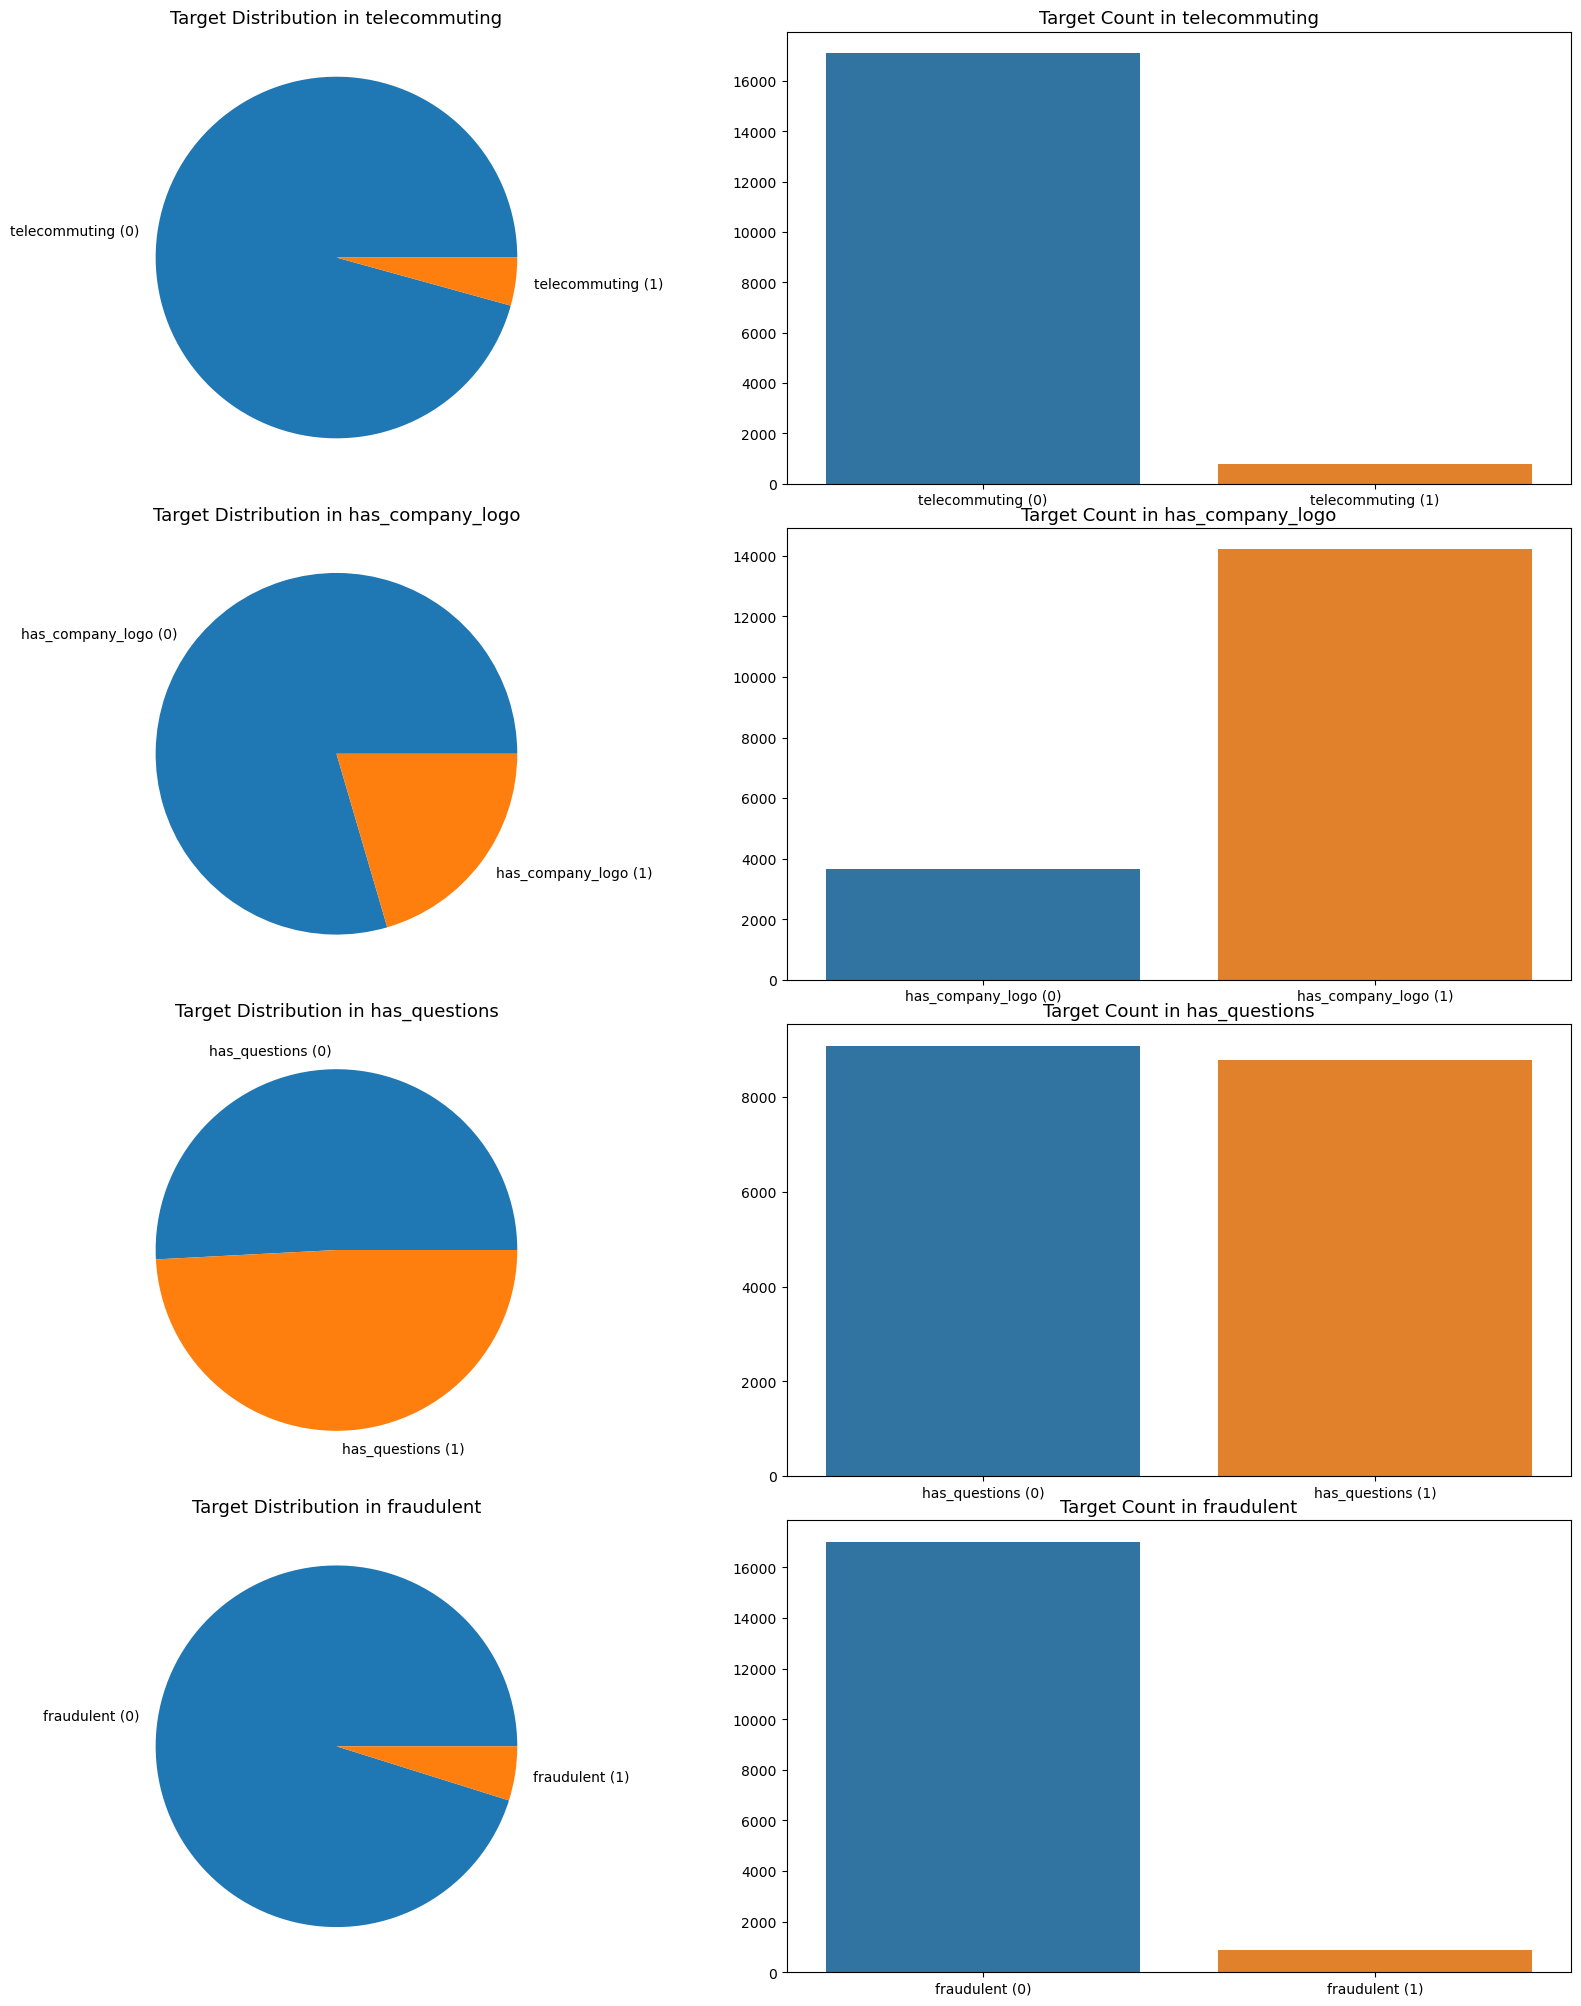

In [10]:
columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(17, len(columns)*5), dpi=100)
plt.tight_layout()

for i, column in enumerate(columns):
    df[column].value_counts().plot(kind='pie', ax=axes[i, 0], labels=[f'{column} (0)', f'{column} (1)'])
    temp = df[column].value_counts()
    sns.barplot(temp.index, temp, ax=axes[i, 1])

    axes[i, 0].set_ylabel(' ')
    axes[i, 1].set_ylabel(' ')
    axes[i, 1].set_xticklabels([f'{column} (0)', f'{column} (1)'])

    axes[i, 0].set_title(f'Target Distribution in {column}', fontsize=13)
    axes[i, 1].set_title(f'Target Count in {column}', fontsize=13)

plt.show()

1. telecommuting:

4% of the values in this column are 0, indicating that a small portion of the job postings do not allow telecommuting.
The remaining 96% of the values are 1, suggesting that the majority of the job postings in the dataset allow telecommuting.

2. has_company_logo:

79% of the values in this column are 0, indicating that a large portion of the job postings do not have a company logo.
The remaining 21% of the values are 1, suggesting that a significant proportion of the job postings in the dataset include a company logo.

3. has_questions:

49% of the values in this column are 0, indicating that approximately half of the job postings do not include questions for applicants.
The remaining 51% of the values are 1, suggesting that a similar proportion of the job postings in the dataset include questions for applicants.


4. fraudulent (target variable):

4% of the values in this column are 0, indicating that a small portion of the job postings are flagged as non-fraudulent.
The remaining 96% of the values are 1, suggesting that the majority of the job postings in the dataset are flagged as fraudulent.
These percentages provide insights into the distribution of the 0s and 1s in each column. It appears that the dataset is imbalanced in terms of the telecommuting, has_company_logo, and has_questions features, with a majority of the values being 1. 
However, in the fraudulent column, there is a small proportion of non-fraudulent job postings (0) compared to the majority of fraudulent job postings (1).

_________________________________________________________________________

### --Categorical Features Analysis

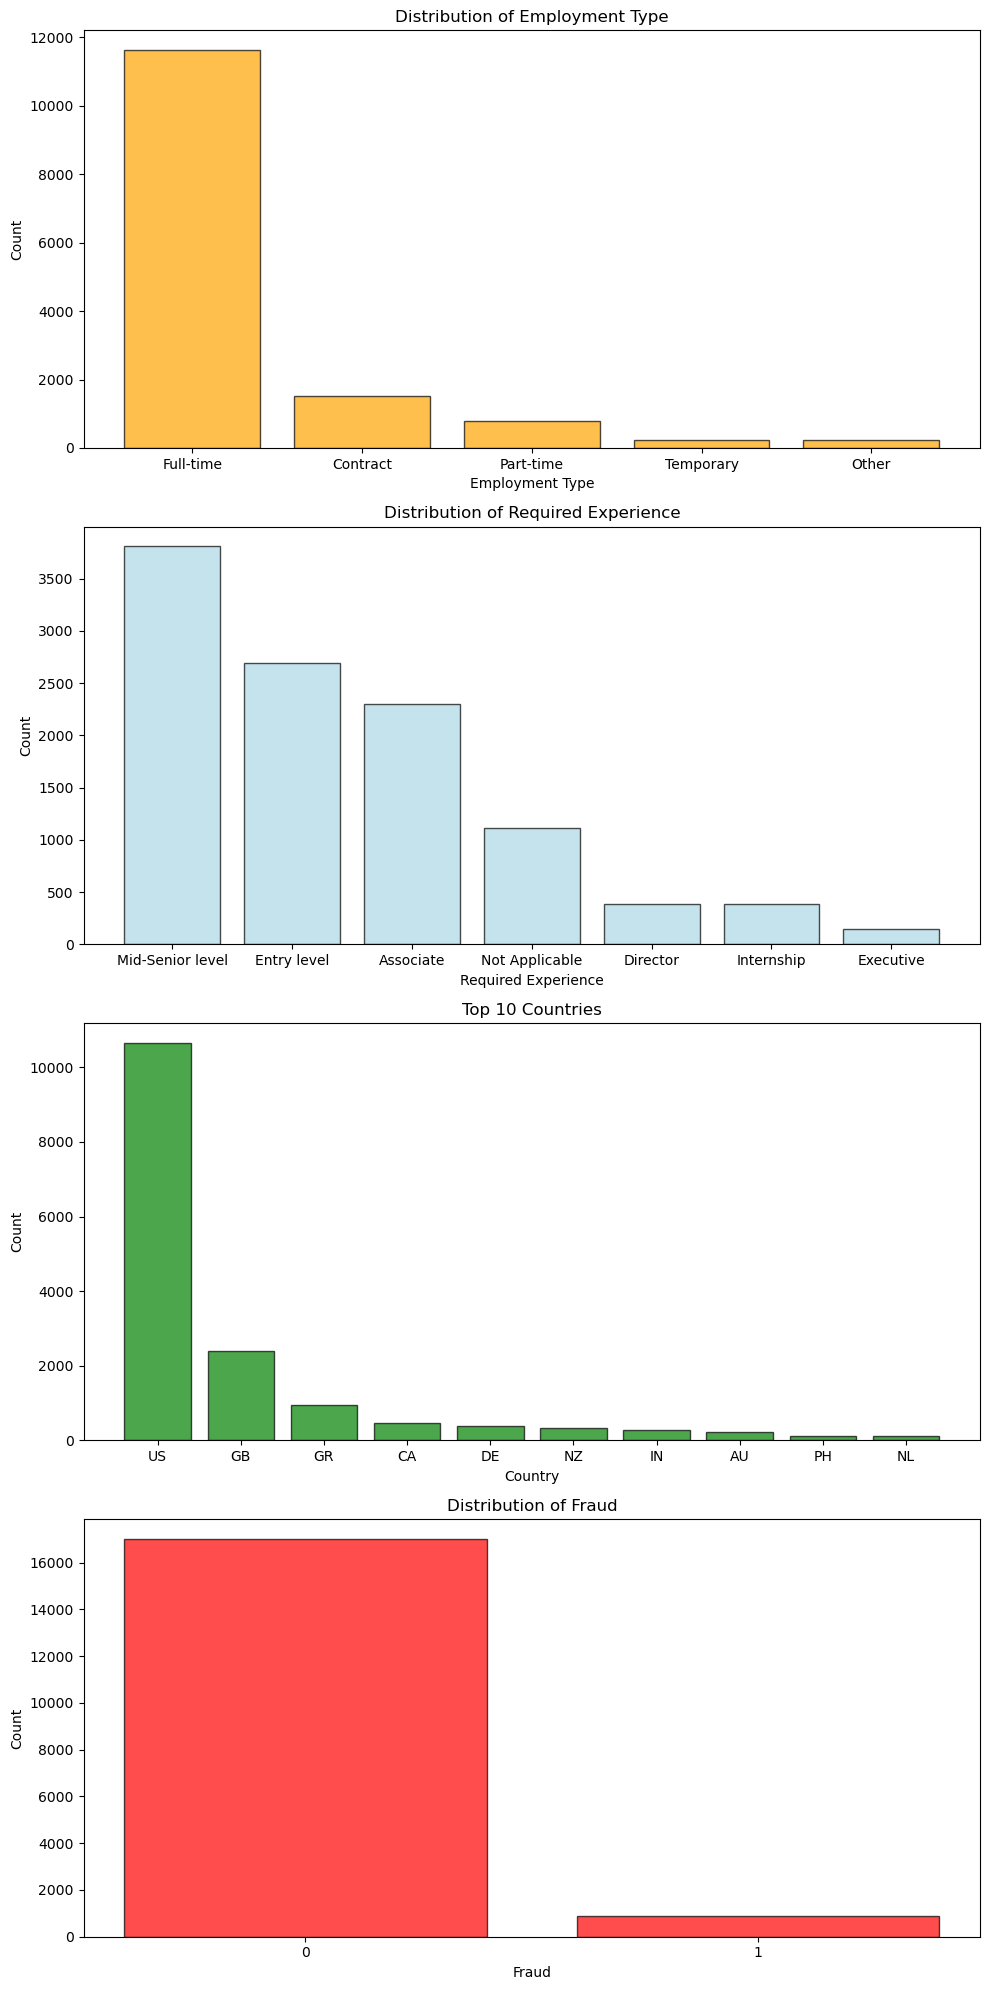

In [11]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 20))

# Remove empty values
employment_type = df['employment_type'].dropna().astype(str)
required_experience = df['required_experience'].dropna().astype(str)
fraudulent = df['fraudulent'].dropna().astype(str)
country = df['location'].str.split(',').str.get(0).dropna().astype(str)  # Extract country from 'location' column

# Sort the values in descending order
employment_type_counts = employment_type.value_counts().sort_values(ascending=False)
required_experience_counts = required_experience.value_counts().sort_values(ascending=False)
fraudulent_counts = fraudulent.value_counts().sort_values(ascending=False)
country_counts = country.value_counts().sort_values(ascending=False).head(10)  # Select top 10 countries

# Plot the histograms
axes[0].bar(employment_type_counts.index, employment_type_counts, color='orange', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Employment Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Employment Type')

axes[1].bar(required_experience_counts.index, required_experience_counts, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Required Experience')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Required Experience')

axes[2].bar(country_counts.index, country_counts, color='green', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Count')
axes[2].set_title('Top 10 Countries')

axes[3].bar(fraudulent_counts.index, fraudulent_counts, color='red', edgecolor='black', alpha=0.7)
axes[3].set_xlabel('Fraud')
axes[3].set_ylabel('Count')
axes[3].set_title('Distribution of Fraud')

plt.tight_layout()
plt.show()



1. Employment Type:

Full-time jobs have the highest count, with approximately 12,000 occurrences in the dataset.
Contract jobs have a count of around 1,800.
Part-time employment type has a count of approximately 500.

2. Required Experience:

Mid-Senior level has the highest count, with around 4,000 occurrences.
Entry level has a count of approximately 2,600.
Associate level has a count of around 2,400.
Director, Internship, and Executive levels have the least count.

3. Location (Country):

The United States (US) has the highest count, with around 11,000 occurrences in the dataset.
The United Kingdom (GB) has a count of around 2,500.
Greece (GR) has a count of approximately 1,000.

4. Fraudulent:

The majority of the values in the fraudulent column are 0, with a count of almost 16,000. This indicates non-fraudulent job postings.
There are around 800 occurrences of the value 1, indicating fraudulent job postings.

In [12]:
# title of jobs which are frequent.

print(df.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


____________________________________________________________________________

## Feature Engineering

### --Dealing with Nan values

In [13]:
def get_null_value_counts(df):   
    null_counts = df.isnull().sum()
    non_null_counts = df.notnull().sum()
    null_counts_table = pd.DataFrame({'Null Count': null_counts, 'Non-Null Count': non_null_counts})
    null_counts_table.sort_values('Null Count', ascending=False, inplace=True)

    return null_counts_table

get_null_value_counts(df)

,Null Count,Non-Null Count
salary_range,15012,2868
department,11547,6333
required_education,8105,9775
benefits,7210,10670
required_experience,7050,10830
function,6455,11425
industry,4903,12977
employment_type,3471,14409
company_profile,3308,14572
requirements,2695,15185


In [14]:
# Removing the columns which are of no use.

columns_to_delete = ['job_id','salary_range', 'department']
df = df.drop(columns=columns_to_delete)

In [15]:
df.fillna(" ",inplace = True)

In [16]:
get_null_value_counts(df)

,Null Count,Non-Null Count
title,0,17880
location,0,17880
company_profile,0,17880
description,0,17880
requirements,0,17880
benefits,0,17880
telecommuting,0,17880
has_company_logo,0,17880
has_questions,0,17880
employment_type,0,17880


In [17]:
#Joining all the text columns

text_columns = ['title', 'location', 'company_profile','description','requirements','benefits']
df['text'] = df[text_columns].apply(lambda x: ' '.join(x), axis = 1)

df = df.drop(columns=text_columns)

_______________________________________________________________________________________

### --Encoding the Categorical Features

In [18]:
#Encoding the Categorical Features into Numerical Features.

from sklearn.preprocessing import LabelEncoder
label_columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  df[i] = lb_make.fit_transform(df[i])

In [19]:
df.columns
data_columns = df.columns.tolist()

data_columns = data_columns[-1:] + data_columns[:-1]
df = df[data_columns]
df.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"Marketing Intern US, NY, New York We're Food52...",0,1,0,3,5,0,0,23,0
1,"Customer Service - Cloud Video Production NZ, ...",0,1,0,2,7,0,76,8,0
2,"Commissioning Machinery Assistant (CMA) US, IA...",0,1,0,0,0,0,0,0,0
3,"Account Executive - Washington DC US, DC, Wash...",0,1,0,2,6,2,23,32,0
4,"Bill Review Manager US, FL, Fort Worth SpotSou...",0,1,1,2,6,2,52,17,0


_________________________________________________________

### --Text Feature Preprocesssing 

In [20]:
# Removing the words from the stop words list
# https://gist.github.com/sebleier/554280

# import nltk
# from nltk.corpus import stopwords
# # Download the stopwords data (only required once)
# nltk.download('stopwords')
# # Get the stopwords list
# stopwords_list = stopwords.words('english')
# stopwords_list


stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 'won', "won't",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'wouldn', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'wasn',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those','very',\
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'so',\
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',\
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'than', 'too',  "wasn't", 'weren', "weren't",\
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", "wouldn't"]

In [21]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", "can not", phrase)

    # general
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"'s", " is", phrase)
    phrase = re.sub(r"'d", " would", phrase)
    phrase = re.sub(r"'ll", " will", phrase)
    phrase = re.sub(r"'t", " not", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"'m", " am", phrase)
    return phrase


def final_preprocess(text):
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    text = text.lower()
    ps = PorterStemmer()
    text = ps.stem(text)
    return text


In [22]:
# Cleaning
df['text'] = df['text'].apply(remove_URL)
df['text'] = df['text'].apply(remove_emoji)
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(final_preprocess)

In [24]:
embeddings_index = {}
with open('glove.840B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            continue

In [25]:
glove_words =  set(embeddings_index.keys())


def convert_sen_to_vec(sentence):
    
    '''A function that takes sentenes as a input and return the vector representation of the same
    Summing up all the vector representation of the words from the glove and then taking the average 
    by dividing with the number of words involved'''
    
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split():
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

In [26]:
converted_data = []

for i in range(0, df.shape[0]):
    converted_data.append(convert_sen_to_vec(df['text'][i]))

converted_df = pd.DataFrame(converted_data)

___________________________________________________________________

### --Feature Scaling

In [27]:
#Scaling the Encoded Features.

scaler = StandardScaler()

scaler = MinMaxScaler()
df[['employment_type', 'required_experience', 'required_education', 'industry', 'function']] = scaler.fit_transform(df[['employment_type', 'required_experience', 'required_education', 'industry', 'function']])


In [30]:
# df.drop(["text"], axis=1, inplace=True)
main_data = pd.concat([converted_df,df], axis=1)

In [31]:
main_data.head()

,0,1,2,3,4,5,6,7,8,9,...,299,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.058630,0.035778,0.015749,-0.044929,-0.021950,0.133582,0.071576,-0.134811,0.109266,1.666173,...,0.079916,0,1,0,1.290338,0.965807,-0.756563,-1.115956,1.063009,0
1,-0.097162,0.136084,-0.018960,-0.087388,0.086279,-0.027445,-0.017212,-0.079061,0.056762,1.846979,...,0.151446,0,1,0,0.321040,1.731617,-0.756563,1.041755,-0.275616,0
2,0.000986,-0.009805,0.062383,-0.036391,0.052179,-0.022229,0.052501,-0.033089,-0.024764,2.048547,...,0.028860,0,1,0,-1.617558,-0.948718,-0.756563,-1.115956,-0.989549,0
3,-0.126997,0.149070,0.011327,-0.070392,0.078811,0.006346,0.003063,0.065353,0.069344,2.062148,...,0.083487,0,1,0,0.321040,1.348712,-0.086046,-0.462964,1.866184,0
4,-0.129901,0.135331,0.037562,-0.054069,0.010841,-0.003460,0.050258,-0.043043,0.103037,2.055314,...,0.000343,0,1,1,0.321040,1.348712,-0.086046,0.360373,0.527559,0


______________________________________________________________

### --Balancing the Target Variable using SMOTE

In [45]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [46]:
sm  = SMOTE(random_state=10)
X_res,Y_res= sm.fit_resample(X,Y)

In [50]:
def split_data(X, Y, test_size=0.3, random_state=10):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_test shape:', y_test.shape)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(X_res,Y_res)

x_train shape: (23765, 8)
y_train shape: (23765,)
x_test shape: (10185, 8)
y_test shape: (10185,)


__________________________________________________

## Model Building

In [51]:
# Logistic Regression
lr = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [52]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [53]:
# XGBoost Classifier
xgb = XGBClassifier(random_state=0)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)

In [54]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred_gnb = gnb.predict(x_test)

_____________________________________________________________

### Model Evaluation

In [59]:
models = [lr, rf, xgb, gnb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Naive Bayes']
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for i, model in enumerate(models):
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.loc[i] = [model_names[i], acc, prec, rec, f1]
    
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.754246   0.783268  0.706273  0.742781
1        Random Forest  0.938537   0.945094  0.931796  0.938398
2              XGBoost  0.939421   0.945368  0.933359  0.939325
3          Naive Bayes  0.749828   0.775940  0.705882  0.739255


___________________________________________________

## Hyper Parameter Tuning of Each Model

In [66]:
#Logistic Regression Tuning

# Define the hyperparameters to tune
lr_params = {'penalty': ['l1', 'l2'],
             'C': [0.001, 0.01, 0.1, 1, 10, 100]}


# Perform grid search to find the best hyperparameters for the model
lr_gs = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1, scoring='f1')
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_


# Make predictions on the test set using the tuned models
lr_pred = lr_best.predict(x_test)

# Evaluate the models using different metrics
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_pred)
lr_cm = confusion_matrix(y_test, lr_pred)

results = pd.DataFrame([['Logistic Regression', lr_acc, lr_prec, lr_rec, lr_f1]], 
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall Score', 'F1 Score'])

In [67]:
#Random Forest Tuning

# Define the hyperparameters to tune
rf_params = {'n_estimators': [100, 500, 1000],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [3, 5, 7, 9]}


# Perform grid search to find the best hyperparameters for the model
rf_gs = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, scoring='f1')
rf_gs.fit(x_train, y_train)
rf_best = rf_gs.best_estimator_


# Make predictions on the test set using the tuned models
rf_pred = rf_best.predict(x_test)

# Evaluate the models using different metrics
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred)
rf_cm = confusion_matrix(y_test, rf_pred)


model_results = pd.DataFrame([['Random Forest', rf_acc, rf_prec, rf_rec, rf_f1]], 
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall Score', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

In [68]:
# XGBoost Classifier Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

xgb_gs = GridSearchCV(xgb, xgb_params, cv=5, n_jobs=-1, scoring='f1')
xgb_gs.fit(x_train, y_train)
xgb_best = xgb_gs.best_estimator_


# Make predictions on the test set using the tuned models
xgb_pred = xgb_best.predict(x_test)


# Evaluate the models using different metrics
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = precision_score(y_test, xgb_pred)
xgb_rec = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

# Add the results to a dataframe
model_results = pd.DataFrame([['XGBoost', xgb_acc, xgb_prec, xgb_rec, xgb_f1]], 
                             columns=['Model', 'Accuracy', 'Precision', 'Recall Score', 'F1 Score'])

results = results.append(model_results, ignore_index=True)

In [69]:
# Gaussian Naive Bayes have very few hyperparameters and model are less sensitive to the hyperparameters.

# Make predictions on the test set using the tuned models
gnb_pred = gnb.predict(x_test)

# Evaluate the models using different metrics
gnb_acc = accuracy_score(y_test, gnb_pred)
gnb_prec = precision_score(y_test, gnb_pred)
gnb_rec = recall_score(y_test, gnb_pred)
gnb_f1 = f1_score(y_test, gnb_pred)
gnb_roc_auc = roc_auc_score(y_test, gnb_pred)
gnb_cm = confusion_matrix(y_test, gnb_pred)

# Add the results to a dataframe
model_results = pd.DataFrame([['Gaussian Naive Bayes', gnb_acc, gnb_prec, gnb_rec, gnb_f1]], 
                             columns=['Model', 'Accuracy', 'Precision', 'Recall Score', 'F1 Score'])

results = results.append(model_results, ignore_index=True)

In [70]:
results

,Model,Accuracy,Precision,Recall Score,F1 Score
0,Logistic Regression,0.754639,0.783333,0.707250,0.743350
1,Random Forest,0.903584,0.891202,0.920461,0.905595
2,XGBoost,0.941679,0.948621,0.934532,0.941524
3,Gaussian Naive Bayes,0.749828,0.775940,0.705882,0.739255


_______________________________________________________________________________________________

1. XGBoost achieved  the highest precision (94.86%), suggesting that it had a high proportion of correctly predicted positive instances compared to the total predicted positive instances.



2. Random Forest had the highest recall score (92.05%), indicating that it had a high proportion of correctly predicted positive instances compared to the actual positive instances.



3. Logistic Regression and Gaussian Naive Bayes had lower performance compared to XGBoost and Random Forest across all metrics.



Based on these, it appears that XGBoost and Random Forest are the top-performing models for this classification task. However, it's important to consider other factors such as computational requirements, interpretability, and specific project requirements when choosing the best model for deployment.